<a href="https://colab.research.google.com/github/mdpw/pytorch-deep-learning/blob/main/04_cnn_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sumani
# https://www.linkedin.com/in/sumanaruban/
# https://github.com/Sumanaruban
# 3-8-2025

# Building and Training a CNN model on CIFAR-10 Dataset Using PyTorch

This notebook demonstrates how to build a Convolutional Neural Network (CNN) using PyTorch to classify images from the CIFAR-10 dataset.

## CIFAR-10 Dataset

The CIFAR-10 dataset is a widely used dataset for training machine learning and computer vision algorithms. It was created by the Canadian Institute For Advanced Research (CIFAR). The CIFAR-10 dataset is often used to benchmark the performance of new algorithms in the field of image classification. It provides a challenging classification task where each image must be correctly labeled with one of the 10 classes.

Here are some key points about the dataset:

* Number of Images: The dataset contains 60,000 color images, each of size 32x32 pixels.
* Classes: There are 10 different classes in the CIFAR-10 dataset. Each class represents a distinct object category: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

* Training and Testing Split: The dataset is divided into two parts:
    * 50,000 training images
    * 10,000 test images

Image Characteristics: All images in the dataset are RGB (color) images, and each image has dimensions of 32x32 pixels. This small size makes the dataset suitable for experimenting with various image recognition algorithms without requiring extensive computational resources.

Normalization: Before training a model on the CIFAR-10 dataset, it is common practice to normalize the images. Normalization helps in speeding up the training process and achieving better performance. Typically, the images are normalized to have a mean and standard deviation of 0.5 for each of the RGB channels.

## Import Libraries

We start by importing the necessary libraries. PyTorch is a popular deep learning framework, and torchvision provides utilities for working with image data.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Preprocess Data

We load the CIFAR-10 dataset and apply transformations to the images. These transformations include random horizontal flipping, random cropping, and normalization. Normalization scales the pixel values to a range that is suitable for training a neural network.

### Define transformations for training and testing datasets

In computer vision, it is a standard practice to transform the dataset. These transformations help in augmenting the training data and standardizing the input, which can lead to better model performance and generalization.

* *transforms.Compose*: transforms.Compose is a method provided by the torchvision.transforms module. It allows you to chain multiple image transformations together. This means that each transformation is applied sequentially to the images.

* *transforms.RandomHorizontalFlip()*: This transformation randomly flips the image horizontally with a probability of 0.5. Horizontal flipping is a common data augmentation technique that helps to make the model invariant to the horizontal orientation of objects in the image. This can improve the model's generalization to unseen data.

* *transforms.RandomCrop(32, padding=4)*: This transformation crops the image to a size of 32x32 pixels. The padding=4 argument specifies that 4 pixels of padding (with zeros) should be added to each side of the image before cropping. The padded image will have dimensions of 40x40 pixels, from which a 32x32 patch is randomly cropped. This data augmentation technique helps the model learn to be robust to slight shifts and translations of the objects within the images.

* *transforms.ToTensor()*: This transformation converts the image from a PIL image or a NumPy array to a PyTorch tensor. This conversion is necessary because PyTorch models expect input data in the form of tensors. The image data is also scaled from a range of [0, 255] to [0, 1].

* *transforms.Normalize()*: This transformation normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each color channel (RGB). Normalization helps to standardize the pixel values and speeds up the convergence of the training process. It also ensures that each feature (pixel value) has a similar scale, which can improve the performance of the neural network. The mean and standard deviation values used here are specific to the CIFAR-10 dataset:
    * Mean: (0.4914, 0.4822, 0.4465)
    * Standard Deviation: (0.2023, 0.1994, 0.2010)

In [3]:
# Define transformations for training and testing datasets
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

### Load training and testing datasets

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


## Define the CNN Architecture

Here, we define the architecture of our CNN. The network consists of three convolutional layers, each followed by a ReLU activation function and max-pooling layer. The convolutional layers detect features in the input images, while the pooling layers reduce the spatial dimensions. Fully connected layers are used at the end to classify the extracted features into one of the 10 classes.

Explanation:
* Conv2d: This layer creates a convolutional kernel that is convolved with the input layer over a single spatial dimension to produce a tensor of outputs.
* MaxPool2d: Applies a 2D max pooling operation over an input signal composed of several input planes.
* Linear: Applies a linear transformation to the incoming data.
* Dropout: Randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## Define Loss Function and Optimizer

The loss function measures how well the network's predictions match the actual labels. We use CrossEntropyLoss, which is suitable for classification tasks. The optimizer updates the network's weights based on the gradients computed during backpropagation. We use the Adam optimizer, which is a popular choice due to its adaptive learning rate.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the Network

We train the network for a specified number of epochs. In each epoch, we pass the entire training dataset through the network, compute the loss, and update the weights. We also evaluate the network on the test dataset after each epoch to monitor its performance.

In [7]:
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print every 100th batch
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    print(f'Full Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_acc = 100. * correct / total
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f'Full Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.9881
Epoch 1, Batch 200, Loss: 1.6554
Epoch 1, Batch 300, Loss: 1.5236
Full Epoch 1, Train Loss: 0.3348, Train Accuracy: 38.17%
Full Epoch 1, Test Loss: 1.3498, Test Accuracy: 50.17%
Epoch 2, Batch 100, Loss: 1.3504
Epoch 2, Batch 200, Loss: 1.2793
Epoch 2, Batch 300, Loss: 1.2391
Full Epoch 2, Train Loss: 0.2774, Train Accuracy: 54.07%
Full Epoch 2, Test Loss: 1.0787, Test Accuracy: 60.99%
Epoch 3, Batch 100, Loss: 1.1408
Epoch 3, Batch 200, Loss: 1.0998
Epoch 3, Batch 300, Loss: 1.0919
Full Epoch 3, Train Loss: 0.2400, Train Accuracy: 61.10%
Full Epoch 3, Test Loss: 0.9854, Test Accuracy: 65.02%
Epoch 4, Batch 100, Loss: 1.0011
Epoch 4, Batch 200, Loss: 0.9571
Epoch 4, Batch 300, Loss: 0.9702
Full Epoch 4, Train Loss: 0.2203, Train Accuracy: 65.67%
Full Epoch 4, Test Loss: 0.8922, Test Accuracy: 69.20%
Epoch 5, Batch 100, Loss: 0.9122
Epoch 5, Batch 200, Loss: 0.8836
Epoch 5, Batch 300, Loss: 0.9035
Full Epoch 5, Train Loss: 0.2063, Train Accuracy: 68.49%


## Visualize Training and Testing Loss

We plot the training and testing loss to visualize the model's learning process over the epochs.

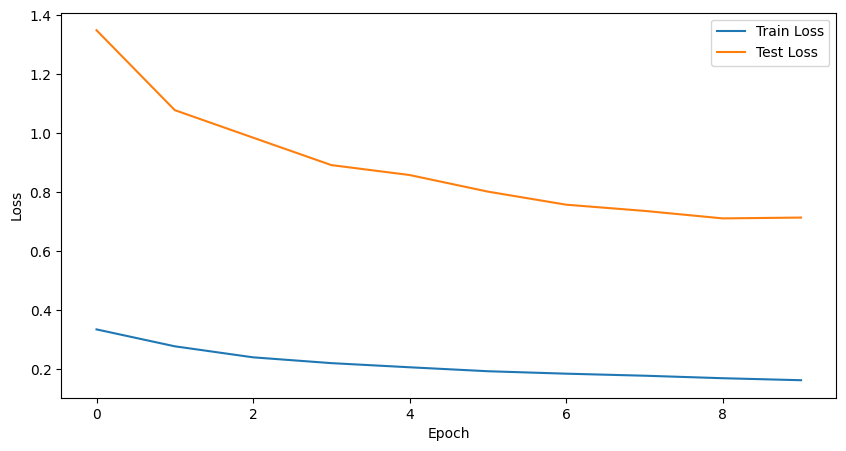

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize Training and Testing Accuracy

We plot the training and testing accuracy to see how well the model is performing on both the training and test datasets.

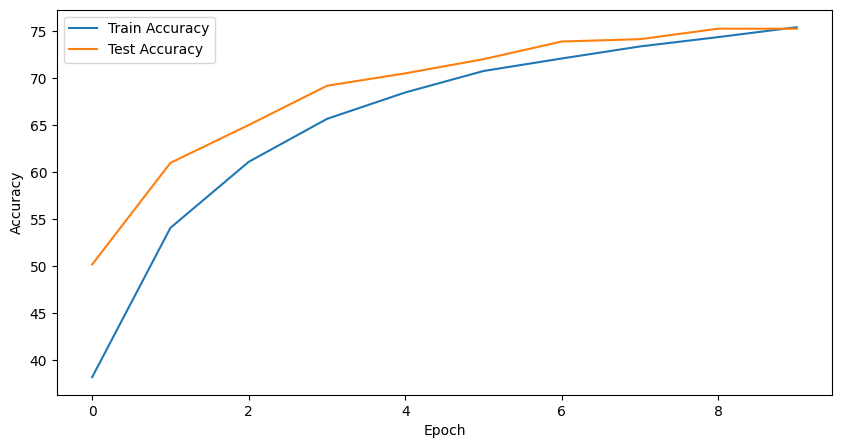

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the Model

We evaluate the trained model on the test dataset to get the overall accuracy and accuracy for each class.


Explanation:
* Overall Accuracy: Measures how many test images are correctly classified by the model.
* Class-wise Accuracy: Provides insight into how well the model performs on each individual class.

In [10]:
net.eval()
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

Accuracy of the network on the 10000 test images: 75.40%
Accuracy of plane: 76.50%
Accuracy of car: 85.30%
Accuracy of bird: 50.10%
Accuracy of cat: 59.30%
Accuracy of deer: 76.40%
Accuracy of dog: 71.20%
Accuracy of frog: 79.00%
Accuracy of horse: 76.30%
Accuracy of ship: 92.70%
Accuracy of truck: 87.20%


## Display Some Test Images and Predictions

We display some test images along with their ground truth labels and the model's predictions to visualize the model's performance.

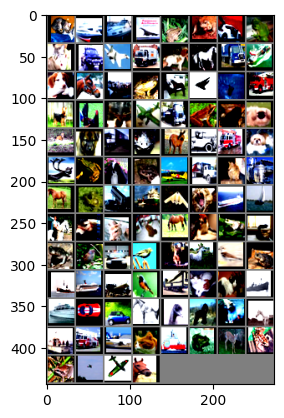

GroundTruth:  cat ship ship plane
Predicted:  cat ship ship ship


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))